In [7]:
import sqlalchemy
import pymysql
import pandas as pd
import json
from pandas import json_normalize
import pandas as pd
import random
import numpy as np
import os
from tqdm.notebook import tqdm
import warnings
from ipywidgets import interact
import ipywidgets as widgets
from ipywidgets import Button, HBox
from IPython.display import display
import asyncio
import matplotlib.pyplot as plt
import xgboost as xgb
warnings.filterwarnings('ignore')

class Project():
    def __init__(self, host = "localhost", port = 3306, user = "root", password = "wangyunhe"):
        # make the connection to mysql using pymysql
        self.port = port
        self.host = host
        self.user = user
        self.password = password
        self.conn = pymysql.connect(host = host,
                               port = port,
                               user = user,
                               password = password,
                               charset = "utf8")
        # create a cursor, which we can use to execute sql 
        self.cursor = self.conn.cursor()
        # create database project
        sql = "CREATE DATABASE IF NOT EXISTS project;"
        self.cursor.execute(sql)
        sql = "USE project;"
        self.cursor.execute(sql)
        
        # prepare sqlalchemy for dataframe operation
        db_connection_str = 'mysql+pymysql://{user}:{password}@{host}:{port}/{db}'\
                            .format(user = self.user, password = self.password, host = self.host, \
                            port = str(self.port), db = 'storage0')
        self.db_connection  = sqlalchemy.create_engine(db_connection_str)
        
        
        # create database for file content storage
        sql = "CREATE DATABASE IF NOT EXISTS storage0;"
        self.cursor.execute(sql)
        sql = "CREATE DATABASE IF NOT EXISTS storage1;"
        self.cursor.execute(sql)
        sql = "CREATE DATABASE IF NOT EXISTS storage2;"
        self.cursor.execute(sql)
        sql = "CREATE DATABASE IF NOT EXISTS storage3;"
        self.cursor.execute(sql)
        
        
        # Table metadata:
        # schema: (meta_id, filename, filetype)
        # meta_id is what we are used as inumber
        # filename is the name of the node
        # filetype is the type of the node. In this case, we have "file" or "directory"
        sql = "USE project;"
        self.cursor.execute(sql)
        sql = "CREATE TABLE IF NOT EXISTS metadata (meta_id INT, \
                                                    filename VARCHAR(100), \
                                                    fileType VARCHAR(100), \
                                                    hasFile INT,\
                                                    PRIMARY KEY (meta_id, filename)\
                                                    );"
        self.cursor.execute(sql)
        
        # Table directory:
        # schema: (parent, child)
        # parent/child
        sql = "CREATE TABLE IF NOT EXISTS directory (parent INT, child INT);"
        self.cursor.execute(sql)
        
        # Table partitions
        # schema: (filename_id, partition)
        sql = "CREATE TABLE IF NOT EXISTS partitions (filename INT, part VARCHAR(1000), storage VARCHAR(100));"
        self.cursor.execute(sql)
        
        # Table fileinfometadata
        sql = "CREATE TABLE IF NOT EXISTS fileinfometadata (meta_id INT, \
                                                            fileType VARCHAR(100), \
                                                            partitions INT, \
                                                            fileName VARCHAR(100), \
                                                            fileLocation VARCHAR(200)\
                                                            );"
        self.cursor.execute(sql)
        
        
        
        # init Table metadata
        try:
            sql = "INSERT INTO metadata VALUES (0, 'root', 'directory', 0);"
            self.cursor.execute(sql)
            self.conn.commit() # must have this line together with insert sql
        except:
            pass
        
        # current_node is used to record the current node
        self.current_node = 0
        
        # max_node_id is used to infer the "actual" directory node or file node
        sql = "SELECT MAX(meta_id) from metadata;"
        self.cursor.execute(sql)
        self.max_node_id = self.cursor.fetchall()
        
        # min_node_id is used to infer the "fake" partition file position node
        sql = "SELECT MAX(meta_id) from metadata;"
        self.cursor.execute(sql)
        self.max_node_id = self.cursor.fetchall()[0][0]
        print("Initialization success!!!")
        

        
    # prepare sqlalchemy for dataframe operation
    def db_connection_change(self, db = 'storage0'):
        db_connection_str = 'mysql+pymysql://{user}:{password}@{host}:{port}/{db}'\
                            .format(user = self.user, password = self.password, host = self.host, \
                            port = str(self.port), db = db)
        self.db_connection  = sqlalchemy.create_engine(db_connection_str)
    
    
    
    
    def mkdir(self, dir_path):
        sql = "USE project;"
        self.cursor.execute(sql)
        if dir_path.endswith('.json'):
            print('Please create a directory, rather than a file')
        else:
            change = False # record whether the dir exists
            path_nodes = dir_path.split('/')
            if dir_path.endswith('/'):
                path_nodes = path_nodes[:-1]
            if '' in path_nodes[1:]:
                print('Not an available path for the contigent "//""')
                return
            sql = "SELECT filename FROM metadata a JOIN (select child from directory where parent = 0) b \
                    ON a.meta_id = b.child;"
            self.cursor.execute(sql)
            node_children_node = [i[0] for i in self.cursor.fetchall()]
            parent_node_id = 0
            for node in path_nodes[1:]:
                # print(node)
                if node in node_children_node:
                    sql = "SELECT meta_id from (SELECT meta_id, filename FROM metadata a JOIN \
                                (select child from directory where parent = %s) b ON a.meta_id = b.child) c \
                                where filename = %s;"
                    self.cursor.execute(sql, (parent_node_id, node))
                    parent_node_id = self.cursor.fetchall()[0][0]
                    sql = "SELECT filename FROM metadata a JOIN \
                            (select child from directory where parent = %s) b \
                            ON a.meta_id = b.child;"
                    self.cursor.execute(sql, (parent_node_id))
                    node_children_node = [i[0] for i in self.cursor.fetchall()]
                else:
                    self.max_node_id += 1
                    
                    # insert metadata into Table metadata
                    sql = "INSERT INTO metadata VALUES (%s, %s, %s, %s);"
                    self.cursor.execute(sql, (self.max_node_id, node, 'directory', 0))
                    self.conn.commit() # must have this line together with insert sql
                    
                    # insert metadata into Table directory
                    sql = "INSERT INTO directory VALUES (%s, %s);"
                    self.cursor.execute(sql, (parent_node_id, self.max_node_id))
                    self.conn.commit() # must have this line together with insert sql
                    
                    parent_node_id = self.max_node_id
                    change = True
                    
                    
            if not change:
                print('The directory ' + dir_path + ' already exists!')
            else:
                print('The directory ' + dir_path + '  is successfully made!')
        
        return 
    
    
    
    
    
    def ls(self, dir_path):
        sql = "USE project;"
        self.cursor.execute(sql)
        if dir_path.endswith('.json'):
            print('Please search for a directory, rather than a file')
            return
        if dir_path[0] != '/':
            print('Please input an available directory path')
            return
        elif dir_path == '/':
            sql = "SELECT filename FROM metadata a JOIN \
                    (select child from directory where parent = 0) b \
                    ON a.meta_id = b.child;"
            self.cursor.execute(sql)
            node_children_node = [i[0] for i in self.cursor.fetchall()]
            print('\t'.join(node_children_node))
            return
        else:
            path_nodes = dir_path.split('/')
            sql = "SELECT filename FROM metadata a JOIN \
                    (select child from directory where parent = 0) b \
                    ON a.meta_id = b.child;"
            self.cursor.execute(sql)
            node_children_node = [i[0] for i in self.cursor.fetchall()]
            parent_node_id = 0
            for node in path_nodes[1:]:
                # print(node)
                if node in node_children_node:
                    sql = "SELECT meta_id from \
                        (SELECT meta_id, filename FROM metadata a JOIN \
                            (select child from directory where parent = %s) b \
                        ON a.meta_id = b.child \
                        ) c \
                        where filename = %s;"
                    self.cursor.execute(sql, (parent_node_id, node))
                    parent_node_id = self.cursor.fetchall()[0][0]
                    sql = "SELECT filename FROM metadata a JOIN \
                            (select child from directory where parent = %s) b \
                            ON a.meta_id = b.child;"
                    self.cursor.execute(sql, (parent_node_id))
                    node_children_node = [i[0] for i in self.cursor.fetchall()]
                    
                    #print(node_children_node)
                else:
                    print('The directory does not exist!')
                    return 
            print('\t'.join(node_children_node))
            return
        
    
    
    
    def put(self, file_name, file_path, k = 5):
        '''
        upload a file from file_name on the local machine to the EDFS file_path
        '''
        try:
            k = int(k)
        except:
            print("Please input an positive integer k!")
            return
        
        sql = "USE project;"
        self.cursor.execute(sql)
        if k < 1:
            print('k partition must be larger than 1')
            return 
        if not file_name.endswith('.json'):
            print('Please upload a file')
            return 
        if file_path.endswith('.json'):
            print('Please choose a directory')
            return
        if not os.path.exists(file_name):
            print('The file does not exist!')
            return
        else:
            # judge whether the similar file already exists in the fils system
            if file_path.endswith('/'):
                file_path.pop()
            filename = file_name.split('/')[-1]
            
            sql = "SELECT meta_id from metadata \
                    where filename = %s and fileType = 'file';"
            self.cursor.execute(sql, (filename))
            fetchall = self.cursor.fetchall()
            if len(fetchall) != 0:
                dire_path = '/' + filename
                print('The same file already exists in the file system')
                parent_node_id = fetchall[0][0]
                while parent_node_id != 0:
                    sql = "SELECT a.meta_id, a.filename FROM metadata a JOIN directory b on a.meta_id = b.parent and b.child = %s;"
                    self.cursor.execute(sql, (parent_node_id))
                    fetchall = self.cursor.fetchall()
                    parent_node_id = fetchall[0][0]
                    if parent_node_id == 0:
                        break
                    _filename = fetchall[0][1]
                    dire_path = '/' + _filename + dire_path
                print("The path of the same file is:", dire_path)
            else:
                # find the parent node id of the file_path
                path_nodes = file_path.split('/')
                sql = "SELECT filename FROM metadata a JOIN \
                        (select child from directory where parent = 0) b \
                        ON a.meta_id = b.child;"
                self.cursor.execute(sql)
                node_children_node = [i[0] for i in self.cursor.fetchall()]
                parent_node_id = 0
                for node in path_nodes[1:]:
                    # print(node)
                    if node in node_children_node:
                        sql = "SELECT meta_id from \
                            (SELECT meta_id, filename FROM metadata a JOIN \
                                (select child from directory where parent = %s) b \
                            ON a.meta_id = b.child \
                            ) c \
                            where filename = %s;"
                        self.cursor.execute(sql, (parent_node_id, node))
                        parent_node_id = self.cursor.fetchall()[0][0]
                        sql = "SELECT filename FROM metadata a JOIN \
                                (select child from directory where parent = %s) b \
                                ON a.meta_id = b.child;"
                        self.cursor.execute(sql, (parent_node_id))
                        node_children_node = [i[0] for i in self.cursor.fetchall()]

                        #print(node_children_node)
                    else:
                        print('The directory does not exist!')
                        return 
                self._parent_node_id = parent_node_id
                
                if 'business' in filename:
                    '''
                    # Deal with the json annd convert it to dataframe!!!!!
                    '''
                    business = []
                    with open(file_name, encoding='utf-8') as f1:
                        for f in f1:
                            business.append(f)
                    business1 = [json.loads(x) for x in business]
                    df_b = pd.json_normalize(business1)
                    self._df_b = df_b
                    cls = list(df_b)
                    # print('The optional sorted key are :', cls)
                    selection = widgets.Select(
                                options = [''] + cls,
                                value = '',
                                description = 'attribute:'
                                )
                    def chosen(_):
                        print("Selected attribute to sort is: {}".format(selection.value))
                        self._sort_value = selection.value

                    selection.observe(chosen, names = "value")
                    display(selection)
                    def wait_for_change(widget, value):
                        future = asyncio.Future()
                        def getvalue(change):
                            # make the new value available
                            future.set_result(change.new)
                            widget.unobserve(getvalue, value)
                        widget.observe(getvalue, value)
                        return future
                    async def f():
                        x = await wait_for_change(selection, 'value')
                        sort_key = x
                        ################################
                        ########The below programs are the same since I did not find way to solve the inference in the function
                        ################################
                        df_b = self._df_b
                        parent_node_id = self._parent_node_id
                        df_b = df_b.sort_values(sort_key).reset_index(drop = True)
                        # insert metadata into Table metadata
                        '''
                        process start
                        '''
                        self.max_node_id += 1
                        file_node_id = self.max_node_id
                        sql = "INSERT INTO metadata VALUES (%s, %s, %s, %s);"
                        self.cursor.execute(sql, (file_node_id, filename, 'file', 0))
                        self.conn.commit() # must have this line together with insert sql

                        # insert metadata into Table directory
                        sql = "INSERT INTO directory VALUES (%s, %s);"
                        self.cursor.execute(sql, (parent_node_id, file_node_id))
                        self.conn.commit() # must have this line together with insert sql    


                        for i in tqdm(range(k), desc = "Creating Partition"):
                            # storage the partitioned file into distributed database
                            if i != k - 1:
                                for n in tqdm(np.random.choice(4, 3, replace = False), desc = 'Creating replica'): # replica number = 3
                                    self.db_connection_change('storage' + str(n))
                                    sql = "USE storage" + str(n) + ";"
                                    self.cursor.execute(sql)
                                    df_b_partition = df_b.iloc[df_b.shape[0] // k * i: df_b.shape[0] // k * (i + 1), :]
                                    df_b_partition.to_sql(filename.split('.json')[0] + '_partition{}'.format(i), self.db_connection, index = True, index_label = 'idx')
                                    # insert metadata into Table partitions
                                    sql = "USE project;"
                                    self.cursor.execute(sql)
                                    sql = "INSERT INTO partitions VALUES (%s, %s, %s);"
                                    self.cursor.execute(sql, (file_node_id, filename.split('.json')[0] + '_partition{}'.format(i), "storage" + str(n)))
                                    self.conn.commit() # must have this line together with insert sql
                            else:
                                for n in tqdm(np.random.choice(4, 3, replace = False), desc = 'Creating replica'):
                                    # storage the partitioned file into distributed database
                                    self.db_connection_change('storage' + str(n))
                                    sql = "USE storage" + str(n) + ";"
                                    self.cursor.execute(sql)
                                    df_b_partition = df_b.iloc[df_b.shape[0] // k * (k - 1):, :]
                                    df_b_partition.to_sql(filename.split('.json')[0] + '_partition{}'.format(k - 1), self.db_connection, index = True, index_label = 'idx')
                                    # insert metadata into Table partitions
                                    sql = "USE project;"
                                    self.cursor.execute(sql)
                                    sql = "INSERT INTO partitions VALUES (%s, %s, %s);"
                                    self.cursor.execute(sql, (file_node_id, filename.split('.json')[0] + '_partition{}'.format(k - 1), "storage" + str(n)))
                                    self.conn.commit() # must have this line together with insert sql



                        

                        # update the file name for each directories
                        path_nodes = file_path.split('/')
                        sql = "UPDATE metadata SET hasFile = hasFile + 1 where meta_id = 0"
                        self.cursor.execute(sql)
                        self.conn.commit()
                        
                        # insert into fileinfometadata
                        sql = "INSERT INTO fileinfometadata VALUES (%s, %s, %s, %s, %s);"
                        self.cursor.execute(sql, (file_node_id, \
                                                  'business', \
                                                  str(k), \
                                                 filename, \
                                                 file_path))
                        self.conn.commit()

                        sql = "SELECT filename FROM metadata a JOIN \
                                (select child from directory where parent = 0) b \
                                ON a.meta_id = b.child;"
                        self.cursor.execute(sql)
                        node_children_node = [i[0] for i in self.cursor.fetchall()]
                        parent_node_id = 0
                        for node in path_nodes[1:]:
                            # print(node)
                            if node in node_children_node:
                                sql = "SELECT meta_id from \
                                    (SELECT meta_id, filename FROM metadata a JOIN \
                                        (select child from directory where parent = %s) b \
                                    ON a.meta_id = b.child \
                                    ) c \
                                    where filename = %s;"
                                self.cursor.execute(sql, (parent_node_id, node))
                                parent_node_id = self.cursor.fetchall()[0][0]
                                # print(parent_node_id)
                                sql = "UPDATE metadata SET hasFile = hasFile + 1 WHERE meta_id = %s"
                                self.cursor.execute(sql, (parent_node_id))
                                self.conn.commit()


                                sql = "SELECT filename FROM metadata a JOIN \
                                        (select child from directory where parent = %s) b \
                                        ON a.meta_id = b.child;"
                                self.cursor.execute(sql, (parent_node_id))
                                node_children_node = [i[0] for i in self.cursor.fetchall()]


                        print(file_name + ' uploaded successfully!')
                        ################################
                        ########The above programs are the same since I did not find way to solve the inference in the function
                        ################################
                        self._df_b = None
                        self._parent_node_id = None
                    asyncio.ensure_future(f())
                    
                    
                    '''
                    # e.g. sort df_b on business_id and partition it by business_id
                    '''
                    

                    
                elif 'review' in filename:
                    '''
                    # Deal with the json annd convert it to dataframe!!!!!
                    '''
                    review = []
                    with open(file_name, encoding = 'utf-8') as g1:
                        for g in g1:
                            review.append(g)
                    review1 = [json.loads(x) for x in review]
                    df_b = pd.json_normalize(review1)
                    self._df_b = df_b
                    cls = list(df_b)
                    # print('The optional sorted key are :', cls)
                    selection = widgets.Select(
                                options = [''] + cls,
                                value = '',
                                description = 'attribute:'
                                )
                    def chosen(_):
                        print("Selected attribute to sort is: {}".format(selection.value))
                        self._sort_value = selection.value

                    selection.observe(chosen, names = "value")
                    display(selection)
                    def wait_for_change(widget, value):
                        future = asyncio.Future()
                        def getvalue(change):
                            # make the new value available
                            future.set_result(change.new)
                            widget.unobserve(getvalue, value)
                        widget.observe(getvalue, value)
                        return future
                    async def f():
                        x = await wait_for_change(selection, 'value')
                        sort_key = x
                        ################################
                        ########The below programs are the same since I did not find way to solve the inference in the function
                        ################################
                        df_b = self._df_b
                        parent_node_id = self._parent_node_id
                        df_b = df_b.sort_values(sort_key).reset_index(drop = True)
                        # insert metadata into Table metadata
                        '''
                        process start
                        '''
                        self.max_node_id += 1
                        file_node_id = self.max_node_id
                        sql = "INSERT INTO metadata VALUES (%s, %s, %s, %s);"
                        self.cursor.execute(sql, (file_node_id, filename, 'file', 0))
                        self.conn.commit() # must have this line together with insert sql

                        # insert metadata into Table directory
                        sql = "INSERT INTO directory VALUES (%s, %s);"
                        self.cursor.execute(sql, (parent_node_id, file_node_id))
                        self.conn.commit() # must have this line together with insert sql    


                        for i in tqdm(range(k), desc = "Creating Partition"):
                            # storage the partitioned file into distributed database
                            if i != k - 1:
                                for n in tqdm(np.random.choice(4, 3, replace = False), desc = 'Creating replica'): # replica number = 3
                                    self.db_connection_change('storage' + str(n))
                                    sql = "USE storage" + str(n) + ";"
                                    self.cursor.execute(sql)
                                    df_b_partition = df_b.iloc[df_b.shape[0] // k * i: df_b.shape[0] // k * (i + 1), :]
                                    df_b_partition.to_sql(filename.split('.json')[0] + '_partition{}'.format(i), self.db_connection, index = True, index_label = 'idx')
                                    # insert metadata into Table partitions
                                    sql = "USE project;"
                                    self.cursor.execute(sql)
                                    sql = "INSERT INTO partitions VALUES (%s, %s, %s);"
                                    self.cursor.execute(sql, (file_node_id, filename.split('.json')[0] + '_partition{}'.format(i), "storage" + str(n)))
                                    self.conn.commit() # must have this line together with insert sql
                            else:
                                for n in tqdm(np.random.choice(4, 3, replace = False), desc = 'Creating replica'):
                                    # storage the partitioned file into distributed database
                                    self.db_connection_change('storage' + str(n))
                                    sql = "USE storage" + str(n) + ";"
                                    self.cursor.execute(sql)
                                    df_b_partition = df_b.iloc[df_b.shape[0] // k * (k - 1):, :]
                                    df_b_partition.to_sql(filename.split('.json')[0] + '_partition{}'.format(k - 1), self.db_connection, index = True, index_label = 'idx')
                                    # insert metadata into Table partitions
                                    sql = "USE project;"
                                    self.cursor.execute(sql)
                                    sql = "INSERT INTO partitions VALUES (%s, %s, %s);"
                                    self.cursor.execute(sql, (file_node_id, filename.split('.json')[0] + '_partition{}'.format(k - 1), "storage" + str(n)))
                                    self.conn.commit() # must have this line together with insert sql



                        # insert into fileinfometadata
                        sql = "INSERT INTO fileinfometadata VALUES (%s, %s, %s, %s, %s);"
                        self.cursor.execute(sql, (file_node_id, \
                                                  'review', \
                                                  str(k), \
                                                 filename, \
                                                 file_path))
                        self.conn.commit()


                        # update the file name for each directories
                        path_nodes = file_path.split('/')
                        sql = "UPDATE metadata SET hasFile = hasFile + 1 where meta_id = 0"
                        self.cursor.execute(sql)
                        self.conn.commit()

                        sql = "SELECT filename FROM metadata a JOIN \
                                (select child from directory where parent = 0) b \
                                ON a.meta_id = b.child;"
                        self.cursor.execute(sql)
                        node_children_node = [i[0] for i in self.cursor.fetchall()]
                        parent_node_id = 0
                        for node in path_nodes[1:]:
                            # print(node)
                            if node in node_children_node:
                                sql = "SELECT meta_id from \
                                    (SELECT meta_id, filename FROM metadata a JOIN \
                                        (select child from directory where parent = %s) b \
                                    ON a.meta_id = b.child \
                                    ) c \
                                    where filename = %s;"
                                self.cursor.execute(sql, (parent_node_id, node))
                                parent_node_id = self.cursor.fetchall()[0][0]
                                # print(parent_node_id)
                                sql = "UPDATE metadata SET hasFile = hasFile + 1 WHERE meta_id = %s"
                                self.cursor.execute(sql, (parent_node_id))
                                self.conn.commit()


                                sql = "SELECT filename FROM metadata a JOIN \
                                        (select child from directory where parent = %s) b \
                                        ON a.meta_id = b.child;"
                                self.cursor.execute(sql, (parent_node_id))
                                node_children_node = [i[0] for i in self.cursor.fetchall()]


                        print(file_name + ' uploaded successfully!')
                        ################################
                        ########The above programs are the same since I did not find way to solve the inference in the function
                        ################################
                        self._df_b = None
                        self._parent_node_id = None
                    asyncio.ensure_future(f())
                    
                    
                    '''
                    # e.g. sort df_b on business_id and partition it by business_id
                    '''
                    
                
                
                elif 'user' in filename:
                    '''
                    # Deal with the json annd convert it to dataframe!!!!!
                    '''
                    user = []
                    with open(file_name, encoding = 'utf-8') as h1:
                        for h in h1:
                            user.append(h)
                    user1 = [json.loads(x) for x in user]
                    df_b = pd.json_normalize(user1)
                    df_b = df_b.drop('friends', axis = 1)
                    self._df_b = df_b
                    cls = list(df_b)
                    # print('The optional sorted key are :', cls)
                    selection = widgets.Select(
                                options = [''] + cls,
                                value = '',
                                description = 'attribute:'
                                )
                    def chosen(_):
                        print("Selected attribute to sort is: {}".format(selection.value))
                        self._sort_value = selection.value

                    selection.observe(chosen, names = "value")
                    display(selection)
                    def wait_for_change(widget, value):
                        future = asyncio.Future()
                        def getvalue(change):
                            # make the new value available
                            future.set_result(change.new)
                            widget.unobserve(getvalue, value)
                        widget.observe(getvalue, value)
                        return future
                    async def f():
                        x = await wait_for_change(selection, 'value')
                        sort_key = x
                        ################################
                        ########The below programs are the same since I did not find way to solve the inference in the function
                        ################################
                        df_b = self._df_b
                        parent_node_id = self._parent_node_id
                        df_b = df_b.sort_values(sort_key).reset_index(drop = True)
                        # insert metadata into Table metadata
                        '''
                        process start
                        '''
                        self.max_node_id += 1
                        file_node_id = self.max_node_id
                        sql = "INSERT INTO metadata VALUES (%s, %s, %s, %s);"
                        self.cursor.execute(sql, (file_node_id, filename, 'file', 0))
                        self.conn.commit() # must have this line together with insert sql

                        # insert metadata into Table directory
                        sql = "INSERT INTO directory VALUES (%s, %s);"
                        self.cursor.execute(sql, (parent_node_id, file_node_id))
                        self.conn.commit() # must have this line together with insert sql    


                        for i in tqdm(range(k), desc = "Creating Partition"):
                            # storage the partitioned file into distributed database
                            if i != k - 1:
                                for n in tqdm(np.random.choice(4, 3, replace = False), desc = 'Creating replica'): # replica number = 3
                                    self.db_connection_change('storage' + str(n))
                                    sql = "USE storage" + str(n) + ";"
                                    self.cursor.execute(sql)
                                    df_b_partition = df_b.iloc[df_b.shape[0] // k * i: df_b.shape[0] // k * (i + 1), :]
                                    df_b_partition.to_sql(filename.split('.json')[0] + '_partition{}'.format(i), self.db_connection, index = True, index_label = 'idx')
                                    # insert metadata into Table partitions
                                    sql = "USE project;"
                                    self.cursor.execute(sql)
                                    sql = "INSERT INTO partitions VALUES (%s, %s, %s);"
                                    self.cursor.execute(sql, (file_node_id, filename.split('.json')[0] + '_partition{}'.format(i), "storage" + str(n)))
                                    self.conn.commit() # must have this line together with insert sql
                            else:
                                for n in tqdm(np.random.choice(4, 3, replace = False), desc = 'Creating replica'):
                                    # storage the partitioned file into distributed database
                                    self.db_connection_change('storage' + str(n))
                                    sql = "USE storage" + str(n) + ";"
                                    self.cursor.execute(sql)
                                    df_b_partition = df_b.iloc[df_b.shape[0] // k * (k - 1):, :]
                                    df_b_partition.to_sql(filename.split('.json')[0] + '_partition{}'.format(k - 1), self.db_connection, index = True, index_label = 'idx')
                                    # insert metadata into Table partitions
                                    sql = "USE project;"
                                    self.cursor.execute(sql)
                                    sql = "INSERT INTO partitions VALUES (%s, %s, %s);"
                                    self.cursor.execute(sql, (file_node_id, filename.split('.json')[0] + '_partition{}'.format(k - 1), "storage" + str(n)))
                                    self.conn.commit() # must have this line together with insert sql



                        # insert into fileinfometadata
                        sql = "INSERT INTO fileinfometadata VALUES (%s, %s, %s, %s, %s);"
                        self.cursor.execute(sql, (file_node_id, \
                                                  'user', \
                                                  str(k), \
                                                 filename, \
                                                 file_path))
                        self.conn.commit()


                        # update the file name for each directories
                        path_nodes = file_path.split('/')
                        sql = "UPDATE metadata SET hasFile = hasFile + 1 where meta_id = 0"
                        self.cursor.execute(sql)
                        self.conn.commit()

                        sql = "SELECT filename FROM metadata a JOIN \
                                (select child from directory where parent = 0) b \
                                ON a.meta_id = b.child;"
                        self.cursor.execute(sql)
                        node_children_node = [i[0] for i in self.cursor.fetchall()]
                        parent_node_id = 0
                        for node in path_nodes[1:]:
                            # print(node)
                            if node in node_children_node:
                                sql = "SELECT meta_id from \
                                    (SELECT meta_id, filename FROM metadata a JOIN \
                                        (select child from directory where parent = %s) b \
                                    ON a.meta_id = b.child \
                                    ) c \
                                    where filename = %s;"
                                self.cursor.execute(sql, (parent_node_id, node))
                                parent_node_id = self.cursor.fetchall()[0][0]
                                # print(parent_node_id)
                                sql = "UPDATE metadata SET hasFile = hasFile + 1 WHERE meta_id = %s"
                                self.cursor.execute(sql, (parent_node_id))
                                self.conn.commit()


                                sql = "SELECT filename FROM metadata a JOIN \
                                        (select child from directory where parent = %s) b \
                                        ON a.meta_id = b.child;"
                                self.cursor.execute(sql, (parent_node_id))
                                node_children_node = [i[0] for i in self.cursor.fetchall()]


                        print(file_name + ' uploaded successfully!')
                        ################################
                        ########The above programs are the same since I did not find way to solve the inference in the function
                        ################################
                        self._df_b = None
                        self._parent_node_id = None
                    asyncio.ensure_future(f())
                    
                    
                    '''
                    # e.g. sort df_b on business_id and partition it by business_id
                    '''
                else:
                    print("Please upload the files about business, user or review_train")
                    return
                
                
                
                
                
                
                

                
                
                
                
                
    
    
    def rm(self, dir_path):
        '''
        delete a file from the dir_path
        '''
        sql = "USE project;"
        self.cursor.execute(sql)
        
        if not dir_path.endswith('.json'):
            print('Please search for a file to delete, rather than a directory')
            return 
        else:
            # get the file's node id
            path_nodes = dir_path.split('/')
            sql = "SELECT filename FROM metadata a JOIN \
                    (select child from directory where parent = 0) b \
                    ON a.meta_id = b.child;"
            self.cursor.execute(sql)
            node_children_node = [i[0] for i in self.cursor.fetchall()]
            parent_node_id = 0
            for node in path_nodes[1:]:
                # print(node)
                if node in node_children_node:
                    sql = "SELECT meta_id from \
                        (SELECT meta_id, filename FROM metadata a JOIN \
                            (select child from directory where parent = %s) b \
                        ON a.meta_id = b.child \
                        ) c \
                        where filename = %s;"
                    self.cursor.execute(sql, (parent_node_id, node))
                    parent_node_id = self.cursor.fetchall()[0][0]
                    sql = "SELECT filename FROM metadata a JOIN \
                            (select child from directory where parent = %s) b \
                            ON a.meta_id = b.child;"
                    self.cursor.execute(sql, (parent_node_id))
                    node_children_node = [i[0] for i in self.cursor.fetchall()]
                    
                    #print(node_children_node)
                else:
                    print('The file does not exist!')
                    return 
            
            # get the partitions of the files
            filename = node
            file_node_id = parent_node_id
            # get how many partitions of this file
            sql = "SELECT DISTINCT part from partitions where filename = %s"
            self.cursor.execute(sql, (file_node_id))
            node_children_node = [i[0] for i in self.cursor.fetchall()]
            for partition_table_name in node_children_node:
                sql = "USE project;"
                self.cursor.execute(sql)
                sql = "SELECT DISTINCT storage from partitions where part = %s"
                self.cursor.execute(sql, (partition_table_name))
                storage_positions = [i[0] for i in self.cursor.fetchall()]
                for storage in storage_positions:
                    
                    sql = "USE " + storage + ";"
                    self.cursor.execute(sql)
                    sql = "DROP TABLE {table_name}".format(table_name = partition_table_name)
                    self.cursor.execute(sql)
                    self.conn.commit()
    
            
            # update the "hasFile" features in table metadata
            path_nodes = dir_path.split('/')
            sql = "USE project;"
            self.cursor.execute(sql)
            sql = "UPDATE metadata SET hasFile = hasFile - 1 where meta_id = 0"
            self.cursor.execute(sql)
            self.conn.commit()

            sql = "SELECT filename FROM metadata a JOIN \
                    (select child from directory where parent = 0) b \
                    ON a.meta_id = b.child;"
            self.cursor.execute(sql)
            node_children_node = [i[0] for i in self.cursor.fetchall()]
            parent_node_id = 0
            for node in path_nodes[1:]:
                # print(node)
                if node in node_children_node:
                    sql = "SELECT meta_id from \
                        (SELECT meta_id, filename FROM metadata a JOIN \
                            (select child from directory where parent = %s) b \
                        ON a.meta_id = b.child \
                        ) c \
                        where filename = %s;"
                    self.cursor.execute(sql, (parent_node_id, node))
                    parent_node_id = self.cursor.fetchall()[0][0]
                    sql = "UPDATE metadata SET hasFile = hasFile - 1 WHERE meta_id = %s"
                    self.cursor.execute(sql, (parent_node_id))
                    self.conn.commit()


                    sql = "SELECT filename FROM metadata a JOIN \
                            (select child from directory where parent = %s) b \
                            ON a.meta_id = b.child;"
                    self.cursor.execute(sql, (parent_node_id))
                    node_children_node = [i[0] for i in self.cursor.fetchall()]
            
            
            # delete metadata for the file
            sql = "USE project;"
            self.cursor.execute(sql)
            sql = "DELETE FROM partitions WHERE filename = %s"
            self.cursor.execute(sql, (file_node_id))
            self.conn.commit()
            sql = "DELETE FROM directory WHERE child = %s"
            self.cursor.execute(sql, (file_node_id))
            self.conn.commit()
            sql = "DELETE FROM metadata WHERE meta_id = %s"
            self.cursor.execute(sql, (file_node_id))
            self.conn.commit()
            sql = "DELETE FROM fileinfometadata WHERE meta_id = %s"
            self.cursor.execute(sql, (file_node_id))
            self.conn.commit()
        
            print('The file has been deleted')
    
    
    
    
    
    def cat(self, dir_path, offset = 0, limit = 1):
        try:
            offset = int(offset)
            limit = int(limit)
        except:
            print("Please input an integer offset and limit!")
            return
        '''
        show the slides of the file.
        The files we use will be too large and will not be suitable for show
        so the user can only see the slides of the file from line offset to line (limit + offset)
        '''
        sql = "USE project;"
        self.cursor.execute(sql)
        if limit > 20:
            print('please not ask to display larger than 20 lines of the data')
            return
        if offset < 0 or limit < 0:
            print('Please input offset and limit which are > 0')
            return
        if not dir_path.endswith('.json'):
            print('Please search for a file, rather than a directory')
            return
        else:
            # get the file's node id
            path_nodes = dir_path.split('/')
            sql = "SELECT filename FROM metadata a JOIN \
                    (select child from directory where parent = 0) b \
                    ON a.meta_id = b.child;"
            self.cursor.execute(sql)
            node_children_node = [i[0] for i in self.cursor.fetchall()]
            parent_node_id = 0
            for node in path_nodes[1:]:
                # print(node)
                if node in node_children_node:
                    sql = "SELECT meta_id from \
                        (SELECT meta_id, filename FROM metadata a JOIN \
                            (select child from directory where parent = %s) b \
                        ON a.meta_id = b.child \
                        ) c \
                        where filename = %s;"
                    self.cursor.execute(sql, (parent_node_id, node))
                    parent_node_id = self.cursor.fetchall()[0][0]
                    sql = "SELECT filename FROM metadata a JOIN \
                            (select child from directory where parent = %s) b \
                            ON a.meta_id = b.child;"
                    self.cursor.execute(sql, (parent_node_id))
                    node_children_node = [i[0] for i in self.cursor.fetchall()]
                    
                    #print(node_children_node)
                else:
                    print('The file does not exist!')
                    return 
            
            # get the partitions of the files
            filename = node
            file_node_id = parent_node_id
            # get how many partitions of this file
            sql = "SELECT DISTINCT part from partitions where filename = %s"
            self.cursor.execute(sql, (file_node_id))
            node_children_node = [i[0] for i in self.cursor.fetchall()]
            res = pd.DataFrame()
            for partition_table_name in node_children_node:
                sql = "USE project;"
                self.cursor.execute(sql)
                sql = "SELECT DISTINCT storage from partitions where part = %s"
                self.cursor.execute(sql, (partition_table_name))
                storage_positions = [i[0] for i in self.cursor.fetchall()]
                for storage in storage_positions:
                    try:
                        sql = "USE " + storage + ";"
                        self.cursor.execute(sql)
                        sql = "SELECT * from {table_name} \
                            where idx < {offset} + {limit} and idx >= {offset}".format(table_name = partition_table_name, limit = str(limit), offset = str(offset))
                        res = pd.concat([res, pd.read_sql_query(sql, self.conn)])
                        break
                    except:
                        continue
                    
            res.reset_index(drop = True, inplace = True)
            res.drop('idx', axis = 1, inplace = True)
            display(res)
            return res
            
    
    
    
    
    
    def rmdir(self, dir_path):
        '''
        If dir_path has files in it, then it will report one of the files it contains and not operate rm
        If there is no files in it, then it will be deleted, and all of its child directory will be deleted either.
        '''
        sql = "USE project;"
        self.cursor.execute(sql)
        
        if dir_path.endswith('.json'):
            print('Please search for a directory to delete, rather than a file')
            return 
        else:
            # get the directory's node id
            if dir_path.endswith('/'):
                dir_path = dir_path[:-1]
            path_nodes = dir_path.split('/')
            sql = "SELECT filename FROM metadata a JOIN \
                    (select child from directory where parent = 0) b \
                    ON a.meta_id = b.child;"
            self.cursor.execute(sql)
            node_children_node = [i[0] for i in self.cursor.fetchall()]
            parent_node_id = 0
            for node in path_nodes[1:]:
                # print(node)
                if node in node_children_node:
                    sql = "SELECT meta_id from \
                        (SELECT meta_id, filename FROM metadata a JOIN \
                            (select child from directory where parent = %s) b \
                        ON a.meta_id = b.child \
                        ) c \
                        where filename = %s;"
                    self.cursor.execute(sql, (parent_node_id, node))
                    parent_node_id = self.cursor.fetchall()[0][0]
                    sql = "SELECT filename FROM metadata a JOIN \
                            (select child from directory where parent = %s) b \
                            ON a.meta_id = b.child;"
                    self.cursor.execute(sql, (parent_node_id))
                    node_children_node = [i[0] for i in self.cursor.fetchall()]
                else:
                    print('The directory does not exist!')
                    return 
            
            
            dir_node_id = parent_node_id
            # print(dir_node_id)
            # find whether the directory contains files
            sql = "SELECT hasFile from metadata where meta_id = %s"
            self.cursor.execute(sql, (dir_node_id))
            hasFile = self.cursor.fetchall()[0][0]
            res = dir_path
            if hasFile != 0:
                print('The dir has files in it, please check:', end = ' ')
                while True:
                    sql = "SELECT meta_id, filename from \
                            (SELECT meta_id, filename, hasFile FROM metadata a JOIN \
                                (select child from directory where parent = %s) b \
                            ON a.meta_id = b.child \
                            ) c \
                            where hasFile > 0;"
                    self.cursor.execute(sql, (dir_node_id))
                    fetchall = self.cursor.fetchall()
                    if len(fetchall) != 0:
                        dir_node_id = fetchall[0][0]
                        filename = fetchall[0][1]
                        res = res + '/' + filename
                    else:
                        break
                print(res)
            else:
                # find all the nodes we need to delete
                delete_nodes = []
                dir_node_id = parent_node_id
                delete_nodes.append(dir_node_id)
                # delete metadata for the file
                sql = "USE project;"
                self.cursor.execute(sql)
                tmp_node_lst = [dir_node_id]
                while True:
                    tmp_lst = []
                    sql = "SELECT child FROM directory WHERE parent = %s;"
                    for node_id in tmp_node_lst:
                        self.cursor.execute(sql, (node_id))
                        fetchall = self.cursor.fetchall()
                        if len(fetchall) != 0:
                            fetchall = [i[0] for i in fetchall]
                            delete_nodes.extend(fetchall)
                            tmp_lst.extend(fetchall)
                    tmp_node_lst = tmp_lst
                    if len(tmp_node_lst) == 0:
                        break
                
                delete_nodes = [str(i) for i in delete_nodes]
                delete_nodes = '(' + ','.join(delete_nodes) + ')'
                
                # delete the nodes
                sql = "DELETE FROM directory WHERE parent in {delete_nodes};".format(delete_nodes = delete_nodes)
                self.cursor.execute(sql)
                self.conn.commit()
                sql = "DELETE FROM directory WHERE child in {delete_nodes};".format(delete_nodes = delete_nodes)
                self.cursor.execute(sql)
                self.conn.commit()
                sql = "DELETE FROM metadata WHERE meta_id in {delete_nodes};".format(delete_nodes = delete_nodes)
                self.cursor.execute(sql)
                self.conn.commit()
                
                print('The directory has been deleted')

            
            
            
            
            
    
    def getPartitionLocations(self, dir_path):
        '''
        return a list contains (DataNode, Table name) for each partitions
        '''
        sql = "USE project;"
        self.cursor.execute(sql)
        
        if not dir_path.endswith('.json'):
            print('Please search for a file, rather than a directory')
            return
        else:
            # get the file's node id
            path_nodes = dir_path.split('/')
            sql = "SELECT filename FROM metadata a JOIN \
                    (select child from directory where parent = 0) b \
                    ON a.meta_id = b.child;"
            self.cursor.execute(sql)
            node_children_node = [i[0] for i in self.cursor.fetchall()]
            parent_node_id = 0
            for node in path_nodes[1:]:
                # print(node)
                if node in node_children_node:
                    sql = "SELECT meta_id from \
                        (SELECT meta_id, filename FROM metadata a JOIN \
                            (select child from directory where parent = %s) b \
                        ON a.meta_id = b.child \
                        ) c \
                        where filename = %s;"
                    self.cursor.execute(sql, (parent_node_id, node))
                    parent_node_id = self.cursor.fetchall()[0][0]
                    sql = "SELECT filename FROM metadata a JOIN \
                            (select child from directory where parent = %s) b \
                            ON a.meta_id = b.child;"
                    self.cursor.execute(sql, (parent_node_id))
                    node_children_node = [i[0] for i in self.cursor.fetchall()]
                    
                    #print(node_children_node)
                else:
                    print('The file does not exist!')
                    return 
            
            # get the partitions of the files
            filename = node
            file_node_id = parent_node_id
            # get how many partitions of this file
            sql = "select part, storage from \
                    (SELECT part, storage, rank() over(partition by part order by storage asc) as rak\
                    from partitions where filename = %s) a\
                   where rak = 1;"
            self.cursor.execute(sql, (file_node_id))
            node_children_node = [i for i in self.cursor.fetchall()]
            for pair in node_children_node:
                print('Partition_name: ' + pair[0] + '-> DataNode: ' + pair[1])
            return node_children_node
        
        
    
    def getPartitionLocations0(self, dir_path):
        '''
        return a list contains (DataNode, Table name) for each partitions
        '''
        sql = "USE project;"
        self.cursor.execute(sql)
        
        if not dir_path.endswith('.json'):
            print('Please search for a file, rather than a directory')
            return
        else:
            # get the file's node id
            path_nodes = dir_path.split('/')
            sql = "SELECT filename FROM metadata a JOIN \
                    (select child from directory where parent = 0) b \
                    ON a.meta_id = b.child;"
            self.cursor.execute(sql)
            node_children_node = [i[0] for i in self.cursor.fetchall()]
            parent_node_id = 0
            for node in path_nodes[1:]:
                # print(node)
                if node in node_children_node:
                    sql = "SELECT meta_id from \
                        (SELECT meta_id, filename FROM metadata a JOIN \
                            (select child from directory where parent = %s) b \
                        ON a.meta_id = b.child \
                        ) c \
                        where filename = %s;"
                    self.cursor.execute(sql, (parent_node_id, node))
                    parent_node_id = self.cursor.fetchall()[0][0]
                    sql = "SELECT filename FROM metadata a JOIN \
                            (select child from directory where parent = %s) b \
                            ON a.meta_id = b.child;"
                    self.cursor.execute(sql, (parent_node_id))
                    node_children_node = [i[0] for i in self.cursor.fetchall()]
                    
                    #print(node_children_node)
                else:
                    print('The file does not exist!')
                    return 
            
            # get the partitions of the files
            filename = node
            file_node_id = parent_node_id
            # get how many partitions of this file
            sql = "select part, storage from \
                    (SELECT part, storage, rank() over(partition by part order by storage asc) as rak\
                    from partitions where filename = %s) a\
                   where rak = 1;"
            self.cursor.execute(sql, (file_node_id))
            node_children_node = [i for i in self.cursor.fetchall()]
            return node_children_node
    
    
    
    
    
    def readPartition(self, dir_path, k):
        '''
        return NameNode(database), Table name, partition_file in pd.DataFrame format
        '''
        try:
            k = int(k)
        except:
            print("Please input an integer k!")
            return
        sql = "USE project;"
        self.cursor.execute(sql)
        
        if not dir_path.endswith('.json'):
            print('Please search for a file, rather than a directory')
            return
        else:
            # get the file's node id
            path_nodes = dir_path.split('/')
            sql = "SELECT filename FROM metadata a JOIN \
                    (select child from directory where parent = 0) b \
                    ON a.meta_id = b.child;"
            self.cursor.execute(sql)
            node_children_node = [i[0] for i in self.cursor.fetchall()]
            parent_node_id = 0
            for node in path_nodes[1:]:
                # print(node)
                if node in node_children_node:
                    sql = "SELECT meta_id from \
                        (SELECT meta_id, filename FROM metadata a JOIN \
                            (select child from directory where parent = %s) b \
                        ON a.meta_id = b.child \
                        ) c \
                        where filename = %s;"
                    self.cursor.execute(sql, (parent_node_id, node))
                    parent_node_id = self.cursor.fetchall()[0][0]
                    sql = "SELECT filename FROM metadata a JOIN \
                            (select child from directory where parent = %s) b \
                            ON a.meta_id = b.child;"
                    self.cursor.execute(sql, (parent_node_id))
                    node_children_node = [i[0] for i in self.cursor.fetchall()]
                    
                    #print(node_children_node)
                else:
                    print('The file does not exist!')
                    return 
            
            # get the partitions of the files
            filename = node
            file_node_id = parent_node_id
            partition_file_name = filename.split('.json')[0] + '_partition{}'.format(k)
            sql = "SELECT storage FROM partitions WHERE filename = %s and part = %s;"
            self.cursor.execute(sql, (file_node_id, partition_file_name))
            res = pd.DataFrame()
            for replica in range(3):
                try:
                    storage = self.cursor.fetchall()[replica][0]
                    sql = "USE " + storage + ";"
                    self.cursor.execute(sql)
                    sql = "SELECT * from " + partition_file_name + ";" 
                    res = pd.concat([res, pd.read_sql_query(sql, self.conn)])
                    break
                except:
                    continue
                    
            # res.reset_index(drop = True, inplace = True)
            # res.drop('idx', axis = 1, inplace = True)
            return storage, partition_file_name, res
    
    
    def get_filename(self, fileType):
        sql = "USE project;"
        self.cursor.execute(sql)
        sql = "SELECT fileName FROM fileinfometadata WHERE fileType = '" + fileType + "' ORDER BY meta_id DESC;"
        self.cursor.execute(sql)
        filename = [i[0] for i in self.cursor.fetchall()]
        selection = widgets.Select(
                    options = [''] + filename,
                    value = '',
                    description = 'File chosen:'
                    )
        def chosen(_):
            self._sort_value = selection.value

        selection.observe(chosen, names = "value")
        display(selection)
        out = widgets.Output()
        def wait_for_change(widget, value):
            future = asyncio.Future()
            def getvalue(change):
                # make the new value available
                future.set_result(change.new)
                widget.unobserve(getvalue, value)
            widget.observe(getvalue, value)
            return future
        async def f():
            x = await wait_for_change(selection, 'value')
            print("Selected " + fileType + " file is: {}".format(x))
            filename = x
            sql = "SELECT partitions, fileName, fileLocation FROM fileinfometadata WHERE fileName = '" + filename + "';"
            self.cursor.execute(sql)
            result = self.cursor.fetchall()
            res = result[0][2] + '/' + result[0][1] + '+' + str(result[0][0])
            out.append_stdout(res)
        asyncio.ensure_future(f())   
        return out
    
    def mapPartition_business(self, business_path, review_path, k_business, k_review, attribute, func): 
        tuple1 = self.readPartition(business_path, k_business)
        tuple2 = self.readPartition(review_path, k_review)
        storage_business = tuple1[0]
        partition_file_name_business = tuple1[1]
        part_business = tuple1[2]
        storage_review = tuple2[0]
        partition_file_name_review = tuple2[1]
        part_review = tuple2[2]
        business_table = storage_business + '.' + partition_file_name_business
        review_table = storage_review + '.' + partition_file_name_review
        if len(attribute) == 1:
            sql = "SELECT " + business_table + '.`' + attribute[0] + "` AS `" + attribute[0] + "`, count(" + review_table + ".stars) AS cnt, sum(" + review_table + ".stars) AS summation FROM " \
                    + review_table + " LEFT JOIN " + business_table + \
                    " ON " + review_table + ".business_id = " + business_table + ".business_id"\
                    + " WHERE " + func + " GROUP BY `" + attribute[0] + "`;"
            
        elif len(attribute) == 2:
            sql = "SELECT " + business_table + '.`' + attribute[0] + "` AS `" + attribute[0] + "`, " + business_table + '.`' + attribute[1] + "` AS `" + attribute[1] +\
                    "`, count(" + review_table + ".stars) AS cnt, sum(" + review_table + ".stars) AS summation FROM " \
                    + review_table + " LEFT JOIN " + business_table + \
                    " ON " + review_table + ".business_id = " + business_table + ".business_id"\
                    + " WHERE " + func + " GROUP BY `" + attribute[0] + "`, `" + attribute[1] + "`;"
            
            
            
        res = pd.read_sql_query(sql, self.conn)
        #print(res.head())
        return res
    
    
    
    def reduce_business(self, business_path, review_path, business_partitions_num, review_train_partitions_num, attribute, func):  
        comb = pd.DataFrame()
        for k_business in tqdm(range(business_partitions_num), desc = "Processing..."):
            for k_review in tqdm(range(review_train_partitions_num), desc = "SubProcessing..."):
                comb = pd.concat([comb, self.mapPartition_business(business_path, review_path, k_business, k_review, attribute, func)])
        '''def f(zip_item):
            k_business, k_review = zip_item
            return self.mapPartition_business(business_path, review_path, k_business, k_review, attribute, func)
        res_list = list(tqdm(map(f, [(i, j) for i in range(business_partitions_num) for j in range(review_train_partitions_num)]), desc = "Processing..."))
            
        return res_list'''
        print('Process data completed!')
        return comb
    
    
    
    def get_business_attribute(self, flag = 1):
        business_cls = ['neighborhood', 'city', 'state', 'stars', 'review_count', 'is_open', 'categories', \
                        'attributes.BikeParking', 'attributes.BusinessAcceptsCreditCards', \
                        'attributes.GoodForKids', 'attributes.HasTV', 'attributes.NoiseLevel', \
                        'attributes.RestaurantsDelivery', 'attributes.RestaurantsTakeOut', 'hours.Monday', \
                        'hours.Tuesday', 'hours.Wednesday', 'hours.Thursday', 'hours.Friday', 'hours.Saturday', \
                        'attributes.Alcohol', 'attributes.Caters', 'attributes.DogsAllowed', \
                        'attributes.GoodForMeal', 'attributes.RestaurantsTableService', \
                        'attributes.WiFi', 'hours.Sunday', \
                        'attributes.Music', 'attributes.Smoking', 'attributes.ByAppointmentOnly', \
                        'attributes.Open24Hours']
        num = 2
        if flag != 1:
            business_cls = ['[ALL]', 'business_id', 'name', 'address', 'latitude', 'longitude'] + business_cls
            num = len(business_cls) - 1
        selection = widgets.Select(
                    options = [''] + business_cls,
                    value = '',
                    description = 'Attribute chosen:'
                    )
        def chosen(_):
            self._sort_value = selection.value

        selection.observe(chosen, names = "value")
        display(selection)
        out = widgets.Output()
        def wait_for_change(widget, value):
            future = asyncio.Future()
            def getvalue(change):
                # make the new value available
                future.set_result(change.new)
                widget.unobserve(getvalue, value)
            widget.observe(getvalue, value)
            return future
        async def f():
            for i in range(num):
                x = await wait_for_change(selection, 'value')
                print("The attribute selected is: {}".format(x))
                out.append_stdout(x)
        asyncio.ensure_future(f())   
        return out 
    
    
    
    
    
    
    def mapPartition_user(self, user_path, review_path, k_user, k_review, attribute, func): 
        tuple1 = self.readPartition(user_path, k_user)
        tuple2 = self.readPartition(review_path, k_review)
        storage_user = tuple1[0]
        partition_file_name_user = tuple1[1]
        part_user = tuple1[2]
        storage_review = tuple2[0]
        partition_file_name_review = tuple2[1]
        part_review = tuple2[2]
        user_table = storage_user + '.' + partition_file_name_user
        review_table = storage_review + '.' + partition_file_name_review
        if len(attribute) == 1:
            sql = "SELECT " + user_table + '.`' + attribute[0] + "` AS `" + attribute[0] + "`, count(" + review_table + ".stars) AS cnt, sum(" + review_table + ".stars) AS summation FROM " \
                    + review_table + " LEFT JOIN " + user_table + \
                    " ON " + review_table + ".user_id = " + user_table + ".user_id"\
                    + " WHERE " + func + " GROUP BY `" + attribute[0] + "`;"
            
        elif len(attribute) == 2:
            sql = "SELECT " + user_table + '.`' + attribute[0] + "` AS `" + attribute[0] + "`, " + user_table + '.`' + attribute[1] + "` AS `" + attribute[1] +\
                    "`, count(" + review_table + ".stars) AS cnt, sum(" + review_table + ".stars) AS summation FROM " \
                    + review_table + " LEFT JOIN " + user_table + \
                    " ON " + review_table + ".user_id = " + user_table + ".user_id"\
                    + " WHERE " + func + " GROUP BY `" + attribute[0] + "`, `" + attribute[1] + "`;"
        res = pd.read_sql_query(sql, self.conn)
        #print(res.head())
        return res
    
    
    
    def reduce_user(self, user_path, review_path, user_partitions_num, review_train_partitions_num, attribute, func):  
        comb = pd.DataFrame()
        for k_user in tqdm(range(user_partitions_num), desc = "Processing..."):
            for k_review in tqdm(range(review_train_partitions_num), desc = "SubProcessing..."):
                comb = pd.concat([comb, self.mapPartition_user(user_path, review_path, k_user, k_review, attribute, func)])
        
        print('Process data completed!')
        return comb
    
    def get_user_attribute(self, flag = 1):
        if flag == 1:
            user_cls = ['review_count', 'yelping_since', 'useful', 'funny', 'cool', 'fans', 'elite', 'compliment_hot', 'compliment_more']
            num = 2
        else:
            user_cls = ['[ALL]', 'user_id', 'name', 'review_count', 'yelping_since', 'useful', 'funny', 'cool', 'fans', 'elite', 'compliment_hot', \
                        'compliment_more', "compliment_profile", "compliment_cute", "compliment_list", "compliment_note",\
                       "compliment_plain", "compliment_cool", "compliment_funny", "compliment_writer", "compliment_photos"]
            num = len(user_cls) - 1
        selection = widgets.Select(
                    options = [''] + user_cls,
                    value = '',
                    description = 'Attribute chosen:'
                    )
        def chosen(_):
            self._sort_value = selection.value

        selection.observe(chosen, names = "value")
        display(selection)
        out = widgets.Output()
        def wait_for_change(widget, value):
            future = asyncio.Future()
            def getvalue(change):
                # make the new value available
                future.set_result(change.new)
                widget.unobserve(getvalue, value)
            widget.observe(getvalue, value)
            return future
        async def f():
            for i in range(num):
                x = await wait_for_change(selection, 'value')
                print("The attribute selected is: {}".format(x))
                out.append_stdout(x)
        asyncio.ensure_future(f())   
        return out 
    
    
    
    
    def get_func(self):
        print("Note that after you input your restriction, press [ENTER]")
        print("IF YOU DON'T WANT TO IMPLE ANY RESTRICTION, PLEASE INPUT '1'")
        text = widgets.Text()
        display(text)
        def text_input(sender1):
            commands = sender1.value
            self._func = commands
            print("Your restriction is (if you input 1, then it means that you set no restriction) : ", self._func)
        text.on_submit(text_input)
    

    
    
    def get_filename(self, fileType):
        sql = "USE project;"
        self.cursor.execute(sql)
        sql = "SELECT fileName FROM fileinfometadata WHERE fileType = '" + fileType + "' ORDER BY meta_id DESC;"
        self.cursor.execute(sql)
        filename = [i[0] for i in self.cursor.fetchall()]
        selection = widgets.Select(
                    options = [''] + filename,
                    value = '',
                    description = 'File chosen:'
                    )
        def chosen(_):
            self._sort_value = selection.value

        selection.observe(chosen, names = "value")
        display(selection)
        out = widgets.Output()
        def wait_for_change(widget, value):
            future = asyncio.Future()
            def getvalue(change):
                # make the new value available
                future.set_result(change.new)
                widget.unobserve(getvalue, value)
            widget.observe(getvalue, value)
            return future
        async def f():
            x = await wait_for_change(selection, 'value')
            print("Selected " + fileType + " file is: {}".format(x))
            filename = x
            sql = "SELECT partitions, fileName, fileLocation FROM fileinfometadata WHERE fileName = '" + filename + "';"
            self.cursor.execute(sql)
            result = self.cursor.fetchall()
            res = result[0][2] + '/' + result[0][1] + '+' + str(result[0][0])
            out.append_stdout(res)
        asyncio.ensure_future(f())   
        return out
    
    
    
    def mapPartition_search(self, path, k, attribute, func): 
        tuple1 = self.readPartition(path, k)
        storage = tuple1[0]
        partition_file_name = tuple1[1]
        part = tuple1[2]
        table = storage + '.' + partition_file_name
        target = ''
        
        for i in range(len(attribute)):
            target += table + ".`" + attribute[i] + "` AS `" + attribute[i] + "` "
            if i != len(attribute) - 1:
                target += ","
        if "[ALL]" in attribute:
            target = "*"
        sql = "SELECT " + target + " FROM " + table + " WHERE " + func + ";"
            


            
        res = pd.read_sql_query(sql, self.conn)
        #print(res.head())
        return res
    
    
    
    def reduce_research(self, path, partitions_num, attribute, func):  
        comb = pd.DataFrame()
        for k in tqdm(range(partitions_num), desc = "Processing..."):
            comb = pd.concat([comb, self.mapPartition_search(path, k, attribute, func)])
        
        print('Process data completed!')
        return comb
    
    def get_review_attribute(self, flag = 1):
        if flag == 1:
            review_cls = ['review_id', 'user_id', 'business_id', 'date', 'stars', 'useful', 'funny', 'cool']
            num = 2
        else:
            review_cls = ["[ALL]", 'review_id', 'user_id', 'business_id', 'date', 'stars', 'useful', 'funny', 'cool']
            num = len(review_cls) - 1
        selection = widgets.Select(
                    options = [''] + review_cls,
                    value = '',
                    description = 'Attribute chosen:'
                    )
        def chosen(_):
            self._sort_value = selection.value

        selection.observe(chosen, names = "value")
        display(selection)
        out = widgets.Output()
        def wait_for_change(widget, value):
            future = asyncio.Future()
            def getvalue(change):
                # make the new value available
                future.set_result(change.new)
                widget.unobserve(getvalue, value)
            widget.observe(getvalue, value)
            return future
        async def f():
            for i in range(num):
                x = await wait_for_change(selection, 'value')
                print("The attribute selected is: {}".format(x))
                out.append_stdout(x)
        asyncio.ensure_future(f())   
        return out
    
    def recommend(self, path1, path2, path3, uid, bid):
        r1 = pd.DataFrame() # review
        for l in range(len(self.getPartitionLocations0(path1))):
            db1 = self.getPartitionLocations0(path1)[l][1]
            tb1 = self.getPartitionLocations0(path1)[l][0]
            sql1 = "USE " + db1 + ";"
            self.cursor.execute(sql1)
            sql2 = "SELECT * from " + tb1 +";"
            res1 = pd.read_sql_query(sql2, self.conn)
            r1 = pd.concat([r1, res1])
        r1 = r1.loc[:,['review_id','user_id','business_id','stars']]
        r2 = pd.DataFrame() # user
        for m in range(len(self.getPartitionLocations0(path2))):
            db2 = self.getPartitionLocations0(path2)[m][1]
            tb2 = self.getPartitionLocations0(path2)[m][0]
            sql3 = "USE " + db2 + ";"
            self.cursor.execute(sql3)
            sql4 = "SELECT * from " + tb2 +";"
            res2 = pd.read_sql_query(sql4, self.conn)
            r2 = pd.concat([r2, res2])
        r2 = r2.loc[:,['user_id','review_count','average_stars']]
        r2.rename(columns={'review_count':'user_review_count','average_stars':'user_stars'}, inplace=True)
        r3 = pd.DataFrame() # business
        for n in range(len(self.getPartitionLocations0(path3))):
            db3 = self.getPartitionLocations0(path3)[n][1]
            tb3 = self.getPartitionLocations0(path3)[n][0]
            sql5 = "USE " + db3 + ";"
            self.cursor.execute(sql5)
            sql6 = "SELECT * from " + tb3 +";"
            res3 = pd.read_sql_query(sql6, self.conn)
            r3 = pd.concat([r3, res3])
        r3 = r3.loc[:,['business_id','review_count','stars']]
        r3.rename(columns={'review_count':'business_review_count','stars':'business_stars'}, inplace=True)
        r_u = r1.join(r2.set_index('user_id'), on='user_id')
        r_u_b = r_u.join(r3.set_index('business_id'), on='business_id')
        x_train = r_u_b.iloc[:,-4:]
        y_train = r_u_b.iloc[:,-5]
        xgb_model = xgb.XGBRegressor(objective='reg:linear', n_estimators=100, n_jobs=-1)
        xgb_model.fit(x_train,y_train)
        x_pred = {}
        x_pred['user_review_count'] = int(r2.loc[r2['user_id']==uid,'user_review_count'])
        x_pred['user_stars'] = float(r2.loc[r2['user_id']==uid,'user_stars'])
        x_pred['business_review_count'] = int(r3.loc[r3['business_id']==bid,'business_review_count'])
        x_pred['business_stars'] = float(r3.loc[r3['business_id']==bid,'business_stars'])
        pred = pd.DataFrame(x_pred, index=[0])
        y_pred = xgb_model.predict(pred)[0]
        print('The predicted star of business ',bid,' from user ',uid,' is ',y_pred)
        return y_pred
    
        
    def endconn(self):
        self.conn.close()
demo = ''    
def YELP_EDFS(host = "localhost", port = 3306, user = "root", password = "wyjdsg1998524"):
    global demo
    try:
        demo = Project(host = host, port = port, user = user, password = password)
    except:
        demo.endconn()
        demo = Project(host = host, port = port, user = user, password = password)
    #####################################
    ########## File Operation ###########
    #####################################
    btn_mkdir = Button(description='Make the directory', button_style = 'primary')
    btn_ls = Button(description='List the content', button_style = 'success')
    btn_put = Button(description='Upload the file', button_style = 'info')
    btn_cat = Button(description='Cat the file', button_style = 'warning')
    btn_rm = Button(description='Remove the file', button_style = 'danger')
    btn_rmdir = Button(description='Remove directory', button_style = 'danger')
    btn_getpartitionlocation = Button(description='Get Partition Locs', button_style = 'danger')
    btn_rmdir.style.button_color = 'darkred'
    btn_getpartitionlocation.style.button_color = 'darkblue'
    def btn_mkdir_click(sender):
        print('Button %s clicked!' % sender.description)
        text = widgets.Text()
        display(text)
        def text_input(sender1):
            commands = sender1.value
            commands = commands.split(' ')
            if len(commands) != 1:
                print('Please give one parameter (dir_path)!')
            else:
                try:
                    demo.mkdir(commands[0])
                except Exception as e:
                    print('Error:', e)
        text.on_submit(text_input)
    def btn_ls_click(sender):
        print('Button %s clicked!' % sender.description)
        text = widgets.Text()
        display(text)
        def text_input(sender1):
            commands = sender1.value
            commands = commands.split(' ')
            if len(commands) != 1 or '' in commands:
                print('Please give one parameter (dir_path)!')
            else:
                try:
                    demo.ls(commands[0])
                except Exception as e:
                    print('Error:', e)
        text.on_submit(text_input)
    def btn_put_click(sender):
        print('Button %s clicked!' % sender.description)
        print('Note: Before upload the file on the file system, you should create a directory on the file system as the target directory')
        print('Such as "/storedata/review_train"')
        print("Please input the parameters like: [file_path on your local machine, directory on the file system, [optional]partition numbers]")
        print('Such as "a/review_train2022_10_30.json /storedata/review_train". Please note that using " " to split the two directories and the input should not end with " ". The partition numbers is defaulted to be 5, and if you want to indicate that, you should input a positive number')
        btn_business = Button(description='Business', button_style = 'primary')
        btn_review = Button(description='Review', button_style = 'success')
        btn_user = Button(description='User', button_style = 'info')
        display(HBox([btn_business, btn_review, btn_user]))
        # the functions below are the same. This is to do the future possible change
        def btn_business_click(sender):
            text = widgets.Text()
            display(text)
            def text_input(sender1):
                commands = sender1.value
                commands = commands.split(' ')

                if len(commands) == 2:
                    if 'business' not in commands[0].split('/')[-1]:
                        print('Please choose business file')
                    else:
                        demo.put(commands[0], commands[1])
                elif len(commands) == 3:
                    if 'business' not in commands[0].split('/')[-1]:
                        print('Please choose business file')
                    else:
                        demo.put(commands[0], commands[1], commands[2])
                else:
                    print('Please give parameters (file_path on your local machine, directory on the file system, [optional]k)!')
            text.on_submit(text_input)
        def btn_review_click(sender):
            text = widgets.Text()
            display(text)
            def text_input(sender1):
                commands = sender1.value
                commands = commands.split(' ')

                if len(commands) == 2:
                    if 'review' not in commands[0].split('/')[-1]:
                        print('Please choose review file')
                    else:
                        demo.put(commands[0], commands[1])
                elif len(commands) == 3:
                    if 'review' not in commands[0].split('/')[-1]:
                        print('Please choose review file')
                    else:
                        demo.put(commands[0], commands[1], commands[2])
                else:
                    print('Please give parameters (file_path on your local machine, directory on the file system, ,[optional]k)!')
            text.on_submit(text_input)
        def btn_user_click(sender):
            text = widgets.Text()
            display(text)
            def text_input(sender1):
                commands = sender1.value
                commands = commands.split(' ')
                if len(commands) == 2:
                    if 'user' not in commands[0].split('/')[-1]:
                        print('Please choose user file')
                    else:
                        demo.put(commands[0], commands[1])
                elif len(commands) == 3:
                    if 'user' not in commands[0].split('/')[-1]:
                        print('Please choose user file')
                    else:
                        demo.put(commands[0], commands[1], commands[2])
                else:
                    print('Please give parameters (file_path on your local machine, directory on the file system, [optional]k)!')
            text.on_submit(text_input)
        btn_business.on_click(btn_business_click)
        btn_review.on_click(btn_review_click)
        btn_user.on_click(btn_user_click)

    def btn_cat_click(sender):
        print('Button %s clicked!' % sender.description)
        print('Due to the showing limit, this function only shows at most 20 lines of the data')
        print("Please input the parameters like: [file_path on the file system, offset line, length of the data]")
        print('Such as "/storedata/business/business_2022_10_30_11.json 37710 20". This means that reading the file from 37710 line to 37729 line')
        text = widgets.Text()
        display(text)
        def text_input(sender1):
            commands = sender1.value
            commands = commands.split(' ')
            if len(commands) != 3 or '' in commands:
                print('Please give one parameter (file_path, offset, length)!')
            else:
                demo.cat(commands[0], commands[1], commands[2])
        text.on_submit(text_input)



    def btn_rm_click(sender):
        print('Button %s clicked!' % sender.description)
        print('Please input the file path you want to delete. End with ".json"')
        text = widgets.Text()
        display(text)
        def text_input(sender1):
            commands = sender1.value
            commands = commands.split(' ')
            if len(commands) != 1 or '' in commands:
                print('Please give one parameter (dir_path)!')
            else:
                demo.rm(commands[0])
        text.on_submit(text_input)
    def btn_rmdir_click(sender):
        print('Button %s clicked!' % sender.description)
        print('Please input the directory path you want to delete. ')
        text = widgets.Text()
        display(text)
        def text_input(sender1):
            commands = sender1.value
            commands = commands.split(' ')
            if len(commands) != 1 or '' in commands:
                print('Please give one parameter (dir_path)!')
            else:
                try:
                    demo.rmdir(commands[0])
                except Exception as e:
                    print('Error:', e)
        text.on_submit(text_input)
    def btn_getpartitionlocation_click(sender):
        print('Button %s clicked!' % sender.description)
        text = widgets.Text()
        display(text)
        def text_input(sender1):
            commands = sender1.value
            commands = commands.split(' ')
            if len(commands) != 1 or '' in commands:
                print('Please give one parameter (dir_path)!')
            else:
                try:
                    demo.getPartitionLocations(commands[0])
                except Exception as e:
                    print('Error:', e)
        text.on_submit(text_input)
    btn_mkdir.on_click(btn_mkdir_click)
    btn_ls.on_click(btn_ls_click)
    btn_put.on_click(btn_put_click)
    btn_cat.on_click(btn_cat_click)
    btn_rm.on_click(btn_rm_click)
    btn_rmdir.on_click(btn_rmdir_click)
    btn_getpartitionlocation.on_click(btn_getpartitionlocation_click)



    #####################################
    ########## Visualization ############
    #####################################
    btn_search_user = Button(description = 'Search For user', button_style = 'danger')
    def btn_search_user_click(sender):
        demo._func = ''
        print('Button %s clicked!' % sender.description)
        out1 = demo.get_filename("user")
        out3 = demo.get_user_attribute(0)
        demo.get_func()
        res_br = pd.DataFrame()
        attribute = ''
        func = ''
        btn_br = Button(description = 'Process data', button_style = 'primary')
        def btn_br_click(sender):
            global res_br
            global attribute
            global func
            attribute = ''
            func = ''
            print('Button %s clicked!' % sender.description)
            if len(out1.outputs) != 0 and len(out3.outputs) != 0 and demo._func != '':
                attribute = [i['text'] for i in out3.outputs]
                print("Your chosen attributes are:", attribute)
                func = demo._func
                demo._func = ''
                path = out1.outputs[0]['text'].split('+')[0]
                partitions_num = int(out1.outputs[0]['text'].split('+')[1])
                res_br = demo.reduce_research(path, partitions_num, attribute, func)
            else:
                print('Please choose the files and at least 1 attributes before using this button')

        btn_br.on_click(btn_br_click)
        display(btn_br)


        btn_br_write = Button(description = 'Write result into the file', button_style = 'primary')
        def btn_br_write_click(sender):
            global res_br
            print('Button %s clicked!' % sender.description)
            print("Please input an available csv file path")
            if res_br.shape[0] != 0:
                text_br_write = widgets.Text()
                display(text_br_write)
                def text_br_write_input(sender1):
                    commands = sender1.value
                    try:
                        res_br.to_csv(commands, index = True)
                        print('Output file success')
                    except Exception as e:
                        print('Error:', e)

                text_br_write.on_submit(text_br_write_input)
            else:
                print('Please process the tmp result before using this button')

        btn_br_write.on_click(btn_br_write_click)
        display(btn_br_write)
    btn_search_user.on_click(btn_search_user_click)





    btn_search_business = Button(description = 'Search For business', button_style = 'warning')
    def btn_search_business_click(sender):
        demo._func = ''
        print('Button %s clicked!' % sender.description)
        out1 = demo.get_filename("business")
        out3 = demo.get_business_attribute(0)
        demo.get_func()
        res_br = pd.DataFrame()
        attribute = ''
        func = ''
        btn_br = Button(description = 'Process data', button_style = 'primary')
        def btn_br_click(sender):
            global res_br
            global attribute
            global func
            attribute = ''
            func = ''
            print('Button %s clicked!' % sender.description)
            if len(out1.outputs) != 0 and len(out3.outputs) != 0 and demo._func != '':
                attribute = [i['text'] for i in out3.outputs]
                print("Your chosen attributes are:", attribute)
                func = demo._func
                demo._func = ''
                path = out1.outputs[0]['text'].split('+')[0]
                partitions_num = int(out1.outputs[0]['text'].split('+')[1])
                res_br = demo.reduce_research(path, partitions_num, attribute, func)
            else:
                print('Please choose the files and 2 attributes before using this button')

        btn_br.on_click(btn_br_click)
        display(btn_br)


        btn_br_write = Button(description = 'Write result into the file', button_style = 'primary')
        def btn_br_write_click(sender):
            global res_br
            print('Button %s clicked!' % sender.description)
            print("Please input an available csv file path")
            if res_br.shape[0] != 0:
                text_br_write = widgets.Text()
                display(text_br_write)
                def text_br_write_input(sender1):
                    commands = sender1.value
                    try:
                        res_br.to_csv(commands, index = True)
                        print('Output file success')
                    except Exception as e:
                        print('Error:', e)

                text_br_write.on_submit(text_br_write_input)
            else:
                print('Please process the tmp result before using this button')

        btn_br_write.on_click(btn_br_write_click)
        display(btn_br_write)
    btn_search_business.on_click(btn_search_business_click)





    btn_search_review = Button(description = 'Search For review', button_style = 'info')
    def btn_search_review_click(sender):
        demo._func = ''
        print('Button %s clicked!' % sender.description)
        out1 = demo.get_filename("review")
        out3 = demo.get_review_attribute(0)
        demo.get_func()
        res_br = pd.DataFrame()
        attribute = ''
        func = ''
        btn_br = Button(description = 'Process data', button_style = 'primary')
        def btn_br_click(sender):
            global res_br
            global attribute
            global func
            attribute = ''
            func = ''
            print('Button %s clicked!' % sender.description)
            if len(out1.outputs) != 0 and len(out3.outputs) != 0 and demo._func != '':
                attribute = [i['text'] for i in out3.outputs]
                print("Your chosen attributes are:", attribute)
                func = demo._func
                demo._func = ''
                path = out1.outputs[0]['text'].split('+')[0]
                partitions_num = int(out1.outputs[0]['text'].split('+')[1])
                res_br = demo.reduce_research(path, partitions_num, attribute, func)
            else:
                print('Please choose the files and 2 attributes before using this button')

        btn_br.on_click(btn_br_click)
        display(btn_br)


        btn_br_write = Button(description = 'Write result into the file', button_style = 'primary')
        def btn_br_write_click(sender):
            global res_br
            print('Button %s clicked!' % sender.description)
            print("Please input an available csv file path")
            if res_br.shape[0] != 0:
                text_br_write = widgets.Text()
                display(text_br_write)
                def text_br_write_input(sender1):
                    commands = sender1.value
                    try:
                        res_br.to_csv(commands, index = True)
                        print('Output file success')
                    except Exception as e:
                        print('Error:', e)

                text_br_write.on_submit(text_br_write_input)
            else:
                print('Please process the tmp result before using this button')

        btn_br_write.on_click(btn_br_write_click)
        display(btn_br_write)
    btn_search_review.on_click(btn_search_review_click)













    btn_business_review = Button(description = 'Business + Review', button_style = 'primary')
    def btn_business_review_click(sender):
        demo._func = ''
        print('Button %s clicked!' % sender.description)
        out1 = demo.get_filename("business")
        out2 = demo.get_filename("review")
        out3 = demo.get_business_attribute()
        demo.get_func()
        res_br = pd.DataFrame()
        attribute = ''
        func = ''
        btn_br = Button(description = 'Process data', button_style = 'primary')
        def btn_br_click(sender):
            global res_br
            global attribute
            global func
            attribute = ''
            func = ''
            print('Button %s clicked!' % sender.description)
            if len(out1.outputs) != 0 and len(out2.outputs) != 0 and len(out3.outputs) != 0 and demo._func != '':
                if len(out3.outputs) == 1 or (len(out3.outputs) == 2 and out3.outputs[1]['text'] == ''):
                    attribute = [out3.outputs[0]['text']]
                else:
                    attribute = [out3.outputs[0]['text'], out3.outputs[1]['text']]
                print("Your choosen attributes are:", attribute)
                func = demo._func
                demo._func = ''
                business_path = out1.outputs[0]['text'].split('+')[0]
                business_partitions_num = int(out1.outputs[0]['text'].split('+')[1])
                review_path = out2.outputs[0]['text'].split('+')[0]
                review_partitions_num = int(out2.outputs[0]['text'].split('+')[1])
                res_br = demo.reduce_business(business_path, review_path, business_partitions_num, review_partitions_num, attribute, func)
            else:
                print('Please choose the files before using this button')

        btn_br.on_click(btn_br_click)
        display(btn_br)

        btn_br_res = Button(description = 'Result', button_style = 'success')
        def btn_br_res_click(sender):
            global res_br
            global attribute
            global func
            print('Button %s clicked!' % sender.description)
            if res_br.shape[0] != 0:
                res_br = res_br.groupby(attribute).sum()
                res_br['avg'] = res_br['summation'] / res_br['cnt']
                display(res_br)
                if len(attribute) == 1:
                    res_br = res_br.reset_index()
                    plt.bar(res_br[attribute[0]], res_br['avg'], label = 'The avg of the stars')
                    plt.title('The Relation between average of the stars and the attribute ' + attribute[0] + ' for business under the restrictions')
                    plt.legend(['The avg of the stars'])
                    plt.rcParams["figure.figsize"] = (14,7)
                    plt.show()
                    plt.bar(res_br[attribute[0]], res_br['cnt'], label = 'The avg of the stars', color = 'orange')
                    plt.title('The Relation between count of the reviews and the attribute ' + attribute[0] + ' for business under the restrictions')
                    plt.legend(['The cnt of the reviews'])
                    plt.rcParams["figure.figsize"] = (14,7)
                    plt.show()

                if len(attribute) == 2:
                    res_br['avg'].unstack(fill_value = 0).plot.bar()
                    plt.title('The Relation between average of the stars and the attribute ' + str(attribute) + ' for business under the restrictions')
                    plt.show()
                    res_br['cnt'].unstack(fill_value = 0).plot.bar()
                    plt.title('The Relation between count of the reviews and the attribute ' + str(attribute) + ' for business under the restrictions')
                    plt.show()


            else:
                print('Please process the data before using this button')

        btn_br_res.on_click(btn_br_res_click)
        display(btn_br_res)


        btn_br_write = Button(description = 'Write result into the file', button_style = 'primary')
        def btn_br_write_click(sender):
            global res_br
            print('Button %s clicked!' % sender.description)
            print("Please input an available csv file path")
            if res_br.shape[0] != 0:
                text_br_write = widgets.Text()
                display(text_br_write)
                def text_br_write_input(sender1):
                    commands = sender1.value
                    try:
                        res_br.to_csv(commands, index = True)
                        print('Output file success')
                    except Exception as e:
                        print('Error:', e)

                text_br_write.on_submit(text_br_write_input)
            else:
                print('Please process the tmp result before using this button')

        btn_br_write.on_click(btn_br_write_click)
        display(btn_br_write)




    btn_business_review.on_click(btn_business_review_click)







    btn_user_review = Button(description = 'User + Review', button_style = 'success')
    def btn_user_review_click(sender):
        demo._func = ''
        print('Button %s clicked!' % sender.description)
        out1 = demo.get_filename("user")
        out2 = demo.get_filename("review")
        out3 = demo.get_user_attribute()
        demo.get_func()
        res_br = pd.DataFrame()
        attribute = ''
        func = ''
        btn_br = Button(description = 'Process data', button_style = 'primary')
        def btn_br_click(sender):
            global res_br
            global attribute
            global func
            attribute = ''
            func = ''
            print('Button %s clicked!' % sender.description)
            if len(out1.outputs) != 0 and len(out2.outputs) != 0 and len(out3.outputs) != 0 and demo._func != '':
                if len(out3.outputs) == 1 or (len(out3.outputs) == 2 and out3.outputs[1]['text'] == ''):
                    attribute = [out3.outputs[0]['text']]
                else:
                    attribute = [out3.outputs[0]['text'], out3.outputs[1]['text']]
                print("Your choosen attributes are:", attribute)
                func = demo._func
                demo._func = ''
                user_path = out1.outputs[0]['text'].split('+')[0]
                user_partitions_num = int(out1.outputs[0]['text'].split('+')[1])
                review_path = out2.outputs[0]['text'].split('+')[0]
                review_partitions_num = int(out2.outputs[0]['text'].split('+')[1])
                res_br = demo.reduce_user(user_path, review_path, user_partitions_num, review_partitions_num, attribute, func)
            else:
                print('Please choose the files and 2 attributes before using this button')

        btn_br.on_click(btn_br_click)
        display(btn_br)

        btn_br_res = Button(description = 'Result', button_style = 'success')
        def btn_br_res_click(sender):
            global res_br
            global attribute
            global func
            print('Button %s clicked!' % sender.description)
            if res_br.shape[0] != 0:
                res_br = res_br.groupby(attribute).sum()
                res_br['avg'] = res_br['summation'] / res_br['cnt']
                display(res_br)
                if len(attribute) == 1:
                    res_br = res_br.reset_index()
                    plt.bar(res_br[attribute[0]], res_br['avg'], label = 'The avg of the stars')
                    plt.title('The Relation between average of the stars and the attribute ' + attribute[0] + ' for business under the restrictions')
                    plt.legend(['The avg of the stars'])
                    plt.rcParams["figure.figsize"] = (14,7)
                    plt.show()
                    plt.bar(res_br[attribute[0]], res_br['cnt'], label = 'The avg of the stars', color = 'orange')
                    plt.title('The Relation between count of the reviews and the attribute ' + attribute[0] + ' for business under the restrictions')
                    plt.legend(['The cnt of the reviews'])
                    plt.rcParams["figure.figsize"] = (14,7)
                    plt.show()

                if len(attribute) == 2:
                    res_br['avg'].unstack(fill_value = 0).plot.bar()
                    plt.title('The Relation between average of the stars and the attribute ' + str(attribute) + ' for business under the restrictions')
                    plt.show()
                    res_br['cnt'].unstack(fill_value = 0).plot.bar()
                    plt.title('The Relation between count of the reviews and the attribute ' + str(attribute) + ' for business under the restrictions')
                    plt.show()

            else:
                print('Please process the data before using this button')

        btn_br_res.on_click(btn_br_res_click)
        display(btn_br_res)


        btn_br_write = Button(description = 'Write result into the file', button_style = 'primary')
        def btn_br_write_click(sender):
            global res_br
            print('Button %s clicked!' % sender.description)
            print("Please input an available csv file path")
            if res_br.shape[0] != 0:
                text_br_write = widgets.Text()
                display(text_br_write)
                def text_br_write_input(sender1):
                    commands = sender1.value
                    try:
                        res_br.to_csv(commands, index = True)
                        print('Output file success')
                    except Exception as e:
                        print('Error:', e)

                text_br_write.on_submit(text_br_write_input)
            else:
                print('Please process the tmp result before using this button')

        btn_br_write.on_click(btn_br_write_click)
        display(btn_br_write)
    btn_user_review.on_click(btn_user_review_click)
    
    
    
    btn_recommend = Button(description = 'Recommender', button_style = 'info')
    btn_recommend.style.button_color = 'darkred'
    def btn_recommend_click(sender):
        demo._func = ''
        print('Button %s clicked!' % sender.description)
        out1 = demo.get_filename("user")
        out2 = demo.get_filename("business")
        out3 = demo.get_filename("review")
        print('Please input user id and business id split by " "')
        text = widgets.Text()
        display(text)
        def rc(sender1):
            commands = sender1.value
            commands = commands.split(' ')
            try:
                user_path = out1.outputs[0]['text'].split('+')[0]
                business_path = out2.outputs[0]['text'].split('+')[0]
                review_path = out3.outputs[0]['text'].split('+')[0]
                res = demo.recommend(review_path, user_path, business_path, commands[0], commands[1])
                return res
            except:
                print('user id or business id not exists')
                
        text.on_submit(rc)
        

    btn_recommend.on_click(btn_recommend_click)



    #####################################
    ########## Tabs #####################
    #####################################
    tab_contents = ['Basic file operation', 'Search + Analysis', 'Prediction']
    children = [HBox([btn_mkdir, btn_ls, btn_put, btn_cat, btn_rm, btn_rmdir, btn_getpartitionlocation]), \
                HBox([btn_search_user, btn_search_business, btn_search_review, btn_business_review, btn_user_review]), \
                HBox([btn_recommend])]
    tab = widgets.Tab()
    tab.children = children
    for index,i in enumerate(tab_contents):
        tab.set_title(index, i)
    display(tab)
def readPartition(path, k):
    return demo.readPartition(path, k)[2]


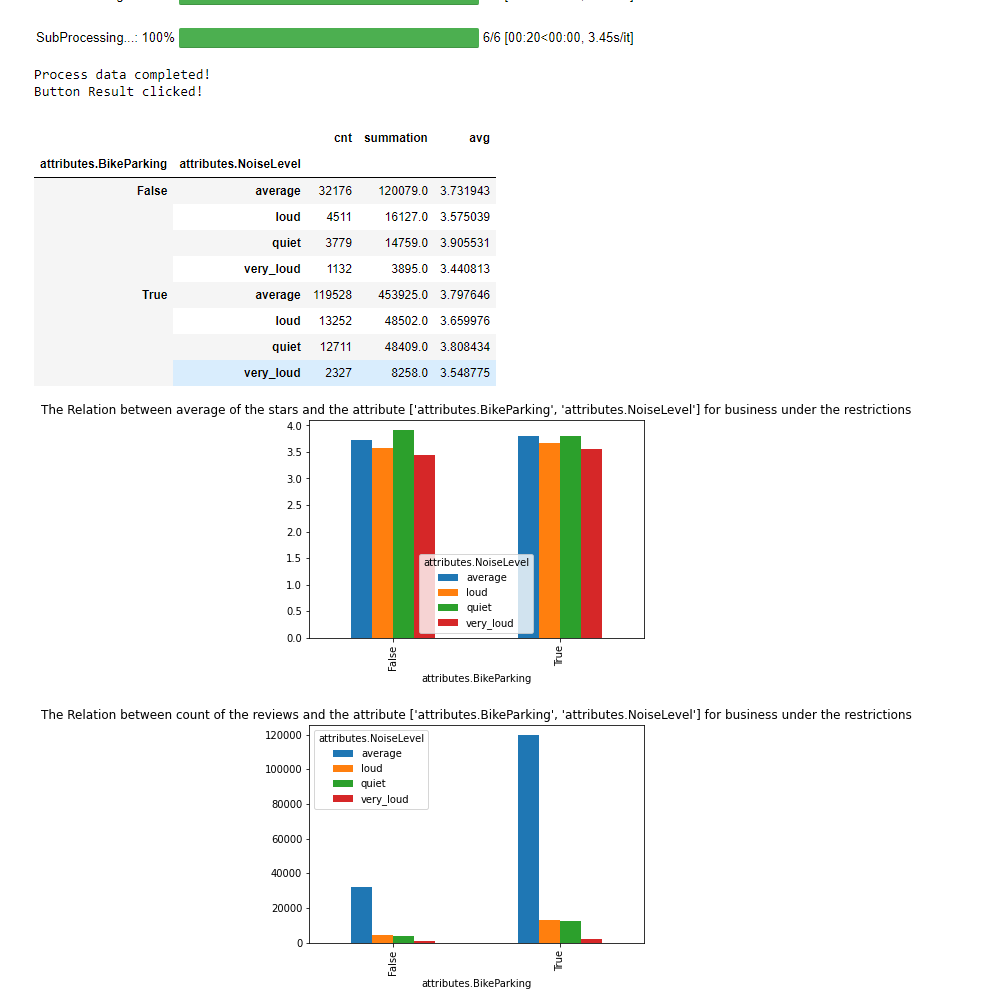

make the directory:  
/yelps  
upload the file:  
a/business_2022_09_30.json /yelp/business 6  
cat:  
/yelp/business/business_2022_10_31.json 37710 20  
rm  
/yelp/business/business_2022_11_12.json  
Get  
/yelp/business/business_2022_10_31.json  
Search for business  
a/business_2022_11_13.json /yelp/business 6  
readPartition("/yelp/business/business_2022_10_31.json", 2)  

In [13]:
YELP_EDFS(host = "localhost", port = 3306, user = "root", password = "wyjdsg1998524")

Initialization success!!!


Button Business + Review clicked!


Select(description='File chosen:', options=('', 'business_2022_09_30.json', 'business_2022_11_11.json', 'busin…

Select(description='File chosen:', options=('', 'review_train2022_10_31.json'), value='')

Select(description='Attribute chosen:', options=('', 'neighborhood', 'city', 'state', 'stars', 'review_count',…

Note that after you input your restriction, press [ENTER]
IF YOU DON'T WANT TO IMPLE ANY RESTRICTION, PLEASE INPUT '1'


Text(value='')

Button(button_style='primary', description='Process data', style=ButtonStyle())

Button(button_style='success', description='Result', style=ButtonStyle())

Button(button_style='primary', description='Write result into the file', style=ButtonStyle())

Selected business file is: business_2022_10_31.json
Selected review file is: review_train2022_10_31.json
The attribute selected is: attributes.BikeParking
The attribute selected is: attributes.NoiseLevel
Your restriction is (if you input 1, then it means that you set no restriction) :  1
Button Process data clicked!
Your choosen attributes are: ['attributes.BikeParking', 'attributes.NoiseLevel']


Processing...:   0%|          | 0/5 [00:00<?, ?it/s]

SubProcessing...:   0%|          | 0/6 [00:00<?, ?it/s]

SubProcessing...:   0%|          | 0/6 [00:00<?, ?it/s]